In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sklearn_evaluation
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 5.0 MB/s 
     |████████████████████████████████| 1.5 MB 65.6 MB/s 
     |████████████████████████████████| 96 kB 7.1 MB/s 
     |████████████████████████████████| 843 kB 77.8 MB/s 
     |████████████████████████████████| 1.6 MB 68.5 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 30.4 MB/s 


In [ ]:
# 1. 
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn_evaluation import plot
from mlxtend.preprocessing import minmax_scaling
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import shap  # package used to calculate Shap values

import tensorflow as tf    
tf.compat.v1.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
game_data = pd.read_csv("/content/drive/MyDrive/SUNS/Zadanie1/train.csv", thousands=',')
game_data_valid = pd.read_csv("/content/drive/MyDrive/SUNS/Zadanie1/test.csv", thousands=',')


Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
game_data.describe()

,D_appid,positive,negative,score,VYMAZAT_price,ccu,languages,publisher_est,developer_est
count,6.286900e+04,6.286900e+04,62869.000000,47427.000000,55809.000000,62869.000000,55783.000000,55710.000000,55676.000000
mean,1.053901e+06,9.712138e+02,158.277704,0.738456,696.530846,83.406989,3.572217,16.101526,5.877416
std,4.835698e+05,1.374712e+04,3936.490884,0.240109,1003.696313,3079.863117,5.075718,43.223335,14.149474
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,6.634100e+05,0.000000e+00,0.000000,0.615385,99.000000,0.000000,1.000000,1.000000,1.000000
50%,1.070320e+06,8.000000e+00,2.000000,0.800000,499.000000,0.000000,1.000000,2.000000,2.000000
75%,1.466500e+06,5.800000e+01,18.000000,0.923077,999.000000,0.000000,4.000000,9.000000,4.000000
max,1.902210e+06,1.089871e+06,868546.000000,1.000000,99900.000000,517487.000000,29.000000,404.000000,138.000000


In [ ]:
game_data.columns

Index(['D_appid', 'D_name', 'positive', 'negative', 'score', 'D_reviews',
       'D_owners', 'coming_soon', 'D_release_date', 'D_genre', 'VYMAZAT_price',
       'is_free', 'ccu', 'english', 'languages', 'D_tags', 'D_developer',
       'D_publisher', 'publisher_est', 'developer_est', 'self_published',
       'has_dlc', 'has_website_linked', 'has_controller_support',
       'is_single_player', 'is_multi_player', 'is_early_access',
       'mature_content', 'Addictive', 'Beautiful', 'Classic', 'Competitive',
       'Cult Classic', 'Difficult', 'Emotional', 'Epic', 'Funny', 'Lore-Rich',
       'Masterpiece', 'Replay Value', 'Short', 'Well-Written'],
      dtype='object')

In [ ]:
game_data['D_release_date']

0        1 Nov, 2000
1        1 Apr, 1999
2        1 May, 2003
3        1 Jun, 2001
4        1 Nov, 1999
            ...     
62864            NaN
62865            NaN
62866            NaN
62867            NaN
62868            NaN
Name: D_release_date, Length: 62869, dtype: object

In [ ]:
# 1.1.1 Z datumoveho stringu rok

def parse_release_data(dataframe):
  release_date_parsed = pd.to_datetime(dataframe['D_release_date'], infer_datetime_format=True)
  dataframe['release_date_parsed'] = release_date_parsed
  dates_dataframe = pd.DataFrame({"year": release_date_parsed.dt.year,
                "month": release_date_parsed.dt.month,
                "day": release_date_parsed.dt.day,
              })
  return pd.concat([dataframe, dates_dataframe], axis=1)
  

game_data = parse_release_data(game_data)
game_data_valid = parse_release_data(game_data_valid)

In [ ]:
game_data.head()

,D_appid,D_name,positive,negative,score,D_reviews,D_owners,coming_soon,D_release_date,D_genre,...,Funny,Lore-Rich,Masterpiece,Replay Value,Short,Well-Written,release_date_parsed,year,month,day
0,10,Counter-Strike,193046,4940,0.975049,Overwhelmingly positive,"10,000,000 .. 20,000,000",False,"1 Nov, 2000",Action,...,False,False,False,False,False,False,2000-11-01,2000.0,11.0,1.0
1,20,Team Fortress Classic,5412,895,0.858094,Very Positive,"5,000,000 .. 10,000,000",False,"1 Apr, 1999",Action,...,True,False,False,False,False,False,1999-04-01,1999.0,4.0,1.0
2,30,Day of Defeat,5003,556,0.899982,Very Positive,"5,000,000 .. 10,000,000",False,"1 May, 2003",Action,...,False,False,False,False,False,False,2003-05-01,2003.0,5.0,1.0
3,40,Deathmatch Classic,1852,412,0.818021,Very Positive,"5,000,000 .. 10,000,000",False,"1 Jun, 2001",Action,...,False,False,False,False,False,False,2001-06-01,2001.0,6.0,1.0
4,50,Half-Life: Opposing Force,13262,662,0.952456,Overwhelmingly positive,"5,000,000 .. 10,000,000",False,"1 Nov, 1999",Action,...,False,False,False,False,False,False,1999-11-01,1999.0,11.0,1.0


In [ ]:
# 1.1.2 Pocet majitelov hry
def parse_owners(dataframe):
  OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  object_cols = ['D_owners']

  owners_parsed = pd.DataFrame(OH_encoder.fit_transform(dataframe[object_cols]))
  # One-hot encoding removed index; put it back
  owners_parsed.index = dataframe.index
  owners_parsed.columns = OH_encoder.get_feature_names_out()
  return pd.concat([dataframe, owners_parsed], axis=1)

game_data = parse_owners(game_data)
game_data_valid = parse_owners(game_data_valid)


In [ ]:
game_data['D_tags'].head()

game_data['D_tags']

0        {'Action': 5379, 'FPS': 4801, 'Multiplayer': 3...
1        {'Action': 745, 'FPS': 306, 'Multiplayer': 257...
2        {'FPS': 787, 'World War II': 248, 'Multiplayer...
3        {'Action': 629, 'FPS': 139, 'Classic': 107, 'M...
4        {'FPS': 881, 'Action': 322, 'Classic': 251, 'S...
                               ...                        
62864                                                   []
62865                                                   []
62866                                                   []
62867                                                   []
62868                                                   []
Name: D_tags, Length: 62869, dtype: object

In [ ]:
def map_parsed_tags(parsed_tag):
  if(parsed_tag == []):
    return []
  else: 
    return parsed_tag.keys()


game_data['tags'] = game_data['D_tags'].map(lambda tag: ast.literal_eval(tag)).map(map_parsed_tags)
game_data_valid['tags'] = game_data_valid['D_tags'].map(lambda tag: ast.literal_eval(tag)).map(map_parsed_tags)
unique_parsed_tags = game_data['tags'].apply(tuple).explode().unique()

unique_parsed_tags

array(['Action', 'FPS', 'Multiplayer', 'Shooter', 'Classic', 'Team-Based',
       'First-Person', 'Competitive', 'Tactical', "1990's", 'e-sports',
       'PvP', 'Old School', 'Military', 'Strategy', 'Survival',
       'Score Attack', '1980s', 'Assassin', 'Violent', 'Hero Shooter',
       'Class-Based', 'Co-op', 'Fast-Paced', 'Retro', 'Online Co-Op',
       'Mod', 'Funny', 'Remake', 'World War II', 'War', 'Historical',
       'Singleplayer', 'Difficult', 'World War I', 'Arena Shooter',
       'Sci-fi', 'Gore', 'Aliens', 'Adventure', 'Atmospheric',
       'Story Rich', 'Silent Protagonist', 'Great Soundtrack', 'Puzzle',
       'Moddable', 'Space', 'Cyberpunk', 'Memes', 'Platformer',
       'Psychological Horror', '3D', 'Conspiracy', 'Cult Classic',
       'Sports', 'Action-Adventure', 'Zombies', 'Short', 'Dystopian ',
       'Physics', 'Horror', 'Simulation', 'Sandbox', 'Realistic',
       'Massively Multiplayer', 'Comedy', 'Benchmark', 'Futuristic',
       'Free to Play', 'Post-apocalyp

In [ ]:
# Parsed from list https://discord.com/channels/756122553956696104/1024188972961894442/1027206762111184906
visual_tags = [
  '2.5D',         '2D',
  '360 Video',    '3D',
  '3D Vision',    'Abstract',
  'Anime',        'Cartoon',
  'Cartoony',     'Cinematic',
  'Colorful',     'Comic Book',
  'Cute',         'First-Person',
  'FMV',          'Hand-drawn',
  'Isometric',    'Minimalist',
  'Noir',         'Pixel Graphics',
  'Psychedelic',  'Realistic',
  'Split Screen', 'Stylized',
  'Text-Based',   'Third Person',
  'Top-Down',     'Voxel',
  'VR',           'Immersive'
]

for tag in visual_tags:
  game_data[tag] = game_data.apply(lambda row: int(tag in row['tags']), axis=1)
  game_data_valid[tag] = game_data_valid.apply(lambda row: int(tag in row['tags']), axis=1)

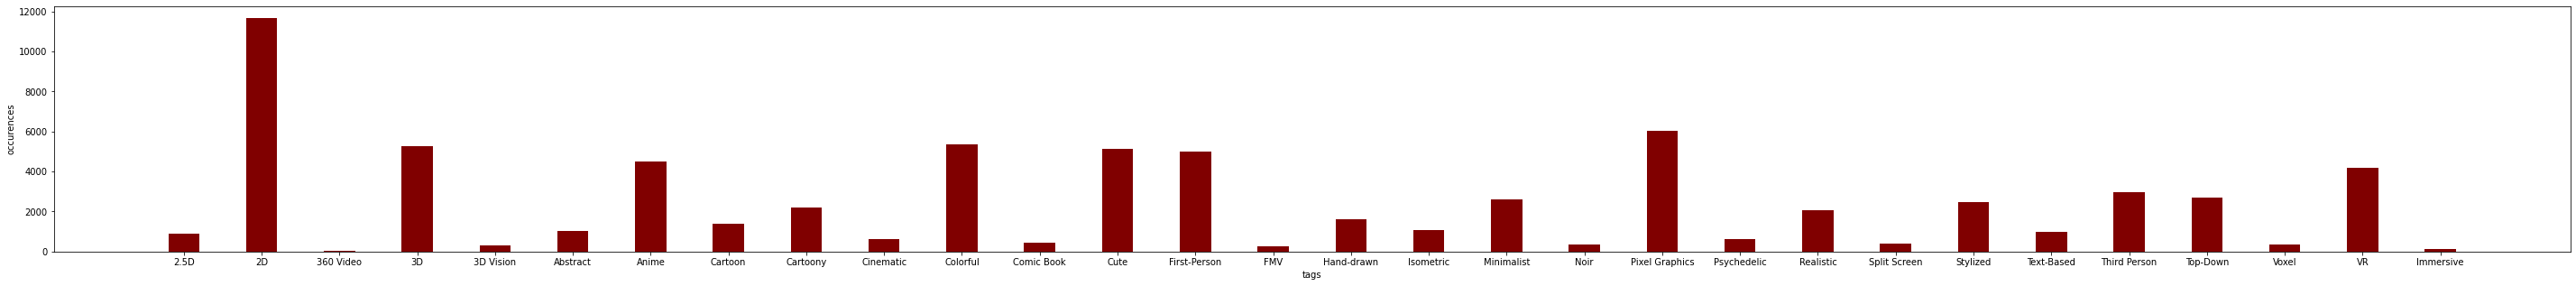

In [ ]:
tags = visual_tags
values = game_data[visual_tags].sum()
  
fig = plt.figure(figsize = (50, 5))
 
# creating the bar plot
plt.bar(tags, values, color ='maroon', width = 0.4)
plt.xlabel('tags')
plt.ylabel('occurences')
plt.show()

In [ ]:
game_data.head()

,D_appid,D_name,positive,negative,score,D_reviews,D_owners,coming_soon,D_release_date,D_genre,...,Psychedelic,Realistic,Split Screen,Stylized,Text-Based,Third Person,Top-Down,Voxel,VR,Immersive
0,10,Counter-Strike,193046,4940,0.975049,Overwhelmingly positive,"10,000,000 .. 20,000,000",False,"1 Nov, 2000",Action,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,5412,895,0.858094,Very Positive,"5,000,000 .. 10,000,000",False,"1 Apr, 1999",Action,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,5003,556,0.899982,Very Positive,"5,000,000 .. 10,000,000",False,"1 May, 2003",Action,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,1852,412,0.818021,Very Positive,"5,000,000 .. 10,000,000",False,"1 Jun, 2001",Action,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,13262,662,0.952456,Overwhelmingly positive,"5,000,000 .. 10,000,000",False,"1 Nov, 1999",Action,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
game_data.shape

(62869, 89)

In [ ]:
# 1.2. Odstrante null hodnoty
missing_values_count = game_data.isnull().sum()

# how many total missing values do we have?
total_cells = np.product(game_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

2.248549284127634


In [ ]:
game_data = game_data.dropna()
game_data_valid = game_data_valid.dropna()

In [ ]:
missing_values_count = game_data.isnull().sum()
missing_values_count

D_appid         0
D_name          0
positive        0
negative        0
score           0
               ..
Third Person    0
Top-Down        0
Voxel           0
VR              0
Immersive       0
Length: 89, dtype: int64

In [ ]:
# Bonus encode D_publisher and D_developer


def frequency_encoder(dataset):
  # Find frequency for each unique categorical value
  D_publisher_encoded = (dataset.groupby('D_publisher').size()) / len(dataset)
  dataset['D_publisher_encoded'] = dataset['D_publisher'].apply(lambda x : D_publisher_encoded[x])

  D_developer_encoded = (dataset.groupby('D_developer').size()) / len(dataset)
  dataset['D_developer_encoded'] = dataset['D_developer'].apply(lambda x : D_developer_encoded[x])

  return dataset

# game_data = frequency_encoder(game_data)
# game_data_valid = frequency_encoder(game_data_valid)

Text(0, 0.5, 'price')

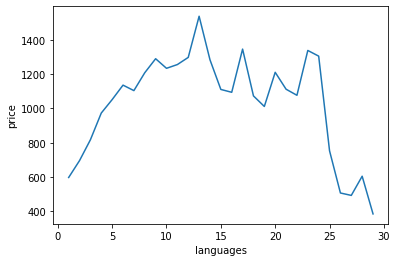

In [ ]:
# 1.3. Analyzujte dataset cez EDA
# Graph representing number of supported languages and price of the game
plot_data = game_data[['languages', 'VYMAZAT_price']]
chart_data = plot_data.groupby(['languages']).mean()
plt.plot(chart_data)
plt.xlabel('languages')
plt.ylabel('price')


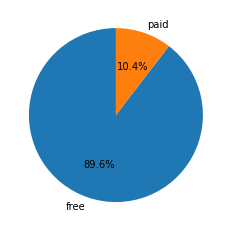

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['free', 'paid']
sizes = game_data['is_free'].value_counts()

fig1, ax1 = plt.subplots()
graph = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',startangle=90)

Text(0, 0.5, 'score')

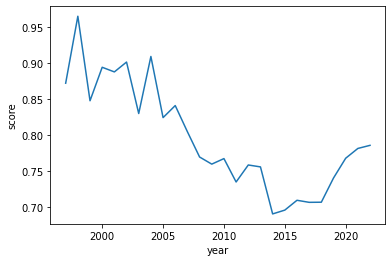

In [ ]:
plot_data = game_data[['year', 'score']]
chart_data = plot_data.groupby(['year']).mean()
plt.plot(chart_data)
plt.xlabel('year')
plt.ylabel('score')

In [ ]:
# Show data from year 1999
game_data.loc[game_data['year'] == 1999]

,D_appid,D_name,positive,negative,score,D_reviews,D_owners,coming_soon,D_release_date,D_genre,...,Psychedelic,Realistic,Split Screen,Stylized,Text-Based,Third Person,Top-Down,Voxel,VR,Immersive
1,20,Team Fortress Classic,5412,895,0.858094,Very Positive,"5,000,000 .. 10,000,000",False,"1 Apr, 1999",Action,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,13262,662,0.952456,Overwhelmingly positive,"5,000,000 .. 10,000,000",False,"1 Nov, 1999",Action,...,0,0,0,0,0,0,0,0,0,0
1691,224920,Legacy of Kain: Soul Reaver,1225,447,0.732656,Mostly Positive,"500,000 .. 1,000,000",False,"8 Sep, 1999","Action, Adventure",...,0,0,0,0,0,1,0,0,0,0


Text(0, 0.5, '% of games')

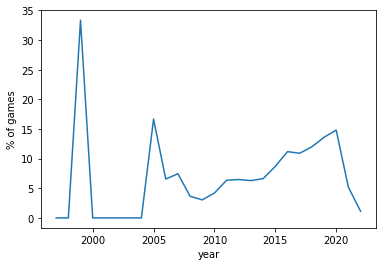

In [ ]:
# Plot free games by year
plot_data = game_data[['year', 'is_free']]
chart_data = plot_data.groupby(['year']).mean() * 100
plt.plot(chart_data)
plt.xlabel('year')
plt.ylabel('% of games')

Text(0, 0.5, 'number of reviews')

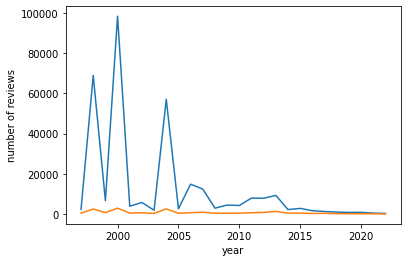

In [ ]:
# Plot positive and negative reviews by year
plot_data = game_data[['year', 'positive', 'negative']]
chart_data = plot_data.groupby(['year'])
plt.plot(chart_data['year'].mean(), chart_data['positive'].mean())
plt.plot(chart_data['year'].mean(), chart_data['negative'].mean())
plt.xlabel('year')
plt.ylabel('number of reviews')


Text(0, 0.5, '% of games')

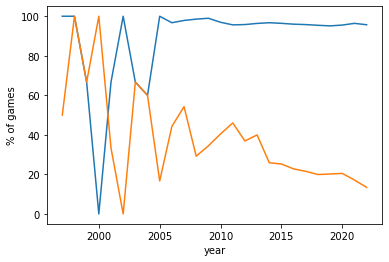

In [ ]:
# Plot single player and multi player games
plot_data = game_data[['year', 'is_single_player', 'is_multi_player']]
chart_data = plot_data.groupby(['year'])
plt.plot(chart_data['year'].mean(), chart_data['is_single_player'].mean()*100)
plt.plot(chart_data['year'].mean(), chart_data['is_multi_player'].mean()*100)
plt.xlabel('year')
plt.ylabel('% of games')

In [ ]:
game_data['is_free'].value_counts()

False    42147
True      4908
Name: is_free, dtype: int64

In [ ]:
game_data.columns

Index(['D_appid', 'D_name', 'positive', 'negative', 'score', 'D_reviews',
       'D_owners', 'coming_soon', 'D_release_date', 'D_genre', 'VYMAZAT_price',
       'is_free', 'ccu', 'english', 'languages', 'D_tags', 'D_developer',
       'D_publisher', 'publisher_est', 'developer_est', 'self_published',
       'has_dlc', 'has_website_linked', 'has_controller_support',
       'is_single_player', 'is_multi_player', 'is_early_access',
       'mature_content', 'Addictive', 'Beautiful', 'Classic', 'Competitive',
       'Cult Classic', 'Difficult', 'Emotional', 'Epic', 'Funny', 'Lore-Rich',
       'Masterpiece', 'Replay Value', 'Short', 'Well-Written',
       'release_date_parsed', 'year', 'month', 'day', 'D_owners_0 .. 20,000',
       'D_owners_1,000,000 .. 2,000,000', 'D_owners_10,000,000 .. 20,000,000',
       'D_owners_100,000 .. 200,000', 'D_owners_2,000,000 .. 5,000,000',
       'D_owners_20,000 .. 50,000', 'D_owners_20,000,000 .. 50,000,000',
       'D_owners_200,000 .. 500,000', 'D_owne

In [ ]:
drop_columns = ['D_appid', 'D_name', 'VYMAZAT_price', 'D_owners', 'D_release_date', 'D_genre', 'ccu', 'D_tags', 'D_developer', 'D_publisher', 'tags', 'D_reviews', 'release_date_parsed']

In [ ]:
# 1.2. Odstrante stlpce, ktore sa nedaju pouzit pri dalsom spracovani
game_data = game_data.drop(drop_columns, axis=1)
game_data_valid = game_data_valid.drop(drop_columns, axis=1)


In [ ]:
# 1.4. Data spravne normalizujte
pd.options.display.max_columns = None
game_data.head()

,positive,negative,score,coming_soon,is_free,english,languages,publisher_est,developer_est,self_published,has_dlc,has_website_linked,has_controller_support,is_single_player,is_multi_player,is_early_access,mature_content,Addictive,Beautiful,Classic,Competitive,Cult Classic,Difficult,Emotional,Epic,Funny,Lore-Rich,Masterpiece,Replay Value,Short,Well-Written,year,month,day,"D_owners_0 .. 20,000","D_owners_1,000,000 .. 2,000,000","D_owners_10,000,000 .. 20,000,000","D_owners_100,000 .. 200,000","D_owners_2,000,000 .. 5,000,000","D_owners_20,000 .. 50,000","D_owners_20,000,000 .. 50,000,000","D_owners_200,000 .. 500,000","D_owners_5,000,000 .. 10,000,000","D_owners_50,000 .. 100,000","D_owners_50,000,000 .. 100,000,000","D_owners_500,000 .. 1,000,000",2.5D,2D,360 Video,3D,3D Vision,Abstract,Anime,Cartoon,Cartoony,Cinematic,Colorful,Comic Book,Cute,First-Person,FMV,Hand-drawn,Isometric,Minimalist,Noir,Pixel Graphics,Psychedelic,Realistic,Split Screen,Stylized,Text-Based,Third Person,Top-Down,Voxel,VR,Immersive
0,193046,4940,0.975049,False,False,True,8.0,33.0,29.0,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,2000.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5412,895,0.858094,False,False,True,9.0,33.0,29.0,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,1999.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5003,556,0.899982,False,False,True,5.0,33.0,29.0,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,2003.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1852,412,0.818021,False,False,True,9.0,33.0,29.0,True,False,False,False,False,True,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,2001.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,13262,662,0.952456,False,False,True,4.0,33.0,13.0,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1999.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cols_to_scale = ['positive', 'negative', 'languages', 'publisher_est', 'developer_est', 'year', 'month', 'day']
scaled_data = minmax_scaling(game_data[cols_to_scale], columns=cols_to_scale)
scaled_data_valid = minmax_scaling(game_data_valid[cols_to_scale], columns=cols_to_scale)
game_data[cols_to_scale] = scaled_data[cols_to_scale]
game_data_valid[cols_to_scale] = scaled_data_valid[cols_to_scale]
game_data.head()

,positive,negative,score,coming_soon,is_free,english,languages,publisher_est,developer_est,self_published,has_dlc,has_website_linked,has_controller_support,is_single_player,is_multi_player,is_early_access,mature_content,Addictive,Beautiful,Classic,Competitive,Cult Classic,Difficult,Emotional,Epic,Funny,Lore-Rich,Masterpiece,Replay Value,Short,Well-Written,year,month,day,"D_owners_0 .. 20,000","D_owners_1,000,000 .. 2,000,000","D_owners_10,000,000 .. 20,000,000","D_owners_100,000 .. 200,000","D_owners_2,000,000 .. 5,000,000","D_owners_20,000 .. 50,000","D_owners_20,000,000 .. 50,000,000","D_owners_200,000 .. 500,000","D_owners_5,000,000 .. 10,000,000","D_owners_50,000 .. 100,000","D_owners_50,000,000 .. 100,000,000","D_owners_500,000 .. 1,000,000",2.5D,2D,360 Video,3D,3D Vision,Abstract,Anime,Cartoon,Cartoony,Cinematic,Colorful,Comic Book,Cute,First-Person,FMV,Hand-drawn,Isometric,Minimalist,Noir,Pixel Graphics,Psychedelic,Realistic,Split Screen,Stylized,Text-Based,Third Person,Top-Down,Voxel,VR,Immersive
0,0.177127,0.005688,0.975049,False,False,True,0.250000,0.079404,0.204380,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,0.12,0.909091,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.004966,0.001030,0.858094,False,False,True,0.285714,0.079404,0.204380,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,0.08,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.004590,0.000640,0.899982,False,False,True,0.142857,0.079404,0.204380,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0.24,0.363636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.001699,0.000474,0.818021,False,False,True,0.285714,0.079404,0.204380,True,False,False,False,False,True,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,0.16,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.012168,0.000762,0.952456,False,False,True,0.107143,0.079404,0.087591,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.08,0.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def remove_iqr_outliers(dataset):
  # Remove outliers with IQR on score column
  Q1,Q3=dataset['score'].quantile([0.25,0.75])
  IQR=Q3-Q1
  lower_limit, upper_limit=Q1-(1.5*IQR),Q3+(1.5*IQR)

  print(lower_limit, upper_limit)
  outlier_data = dataset[(dataset['score'] < lower_limit) | (dataset['score'] > upper_limit)]
  dataset = dataset.drop(outlier_data.index)
  
  return dataset

# Drop outliers
# game_data = remove_iqr_outliers(game_data)
# game_data_valid = remove_iqr_outliers(game_data_valid)

In [ ]:
# Transform boolean values to float
game_data = game_data.apply(lambda column: column.astype(float), axis=1)
game_data_valid = game_data_valid.apply(lambda column: column.astype(float), axis=1)

In [ ]:
game_data_valid = game_data_valid.drop(game_data_valid[game_data_valid['is_free']==False].sample(frac=.8).index)
game_data = game_data.drop(game_data[game_data['is_free']==False].sample(frac=.8).index)

In [ ]:
game_data.head()

,positive,negative,score,coming_soon,is_free,english,languages,publisher_est,developer_est,self_published,has_dlc,has_website_linked,has_controller_support,is_single_player,is_multi_player,is_early_access,mature_content,Addictive,Beautiful,Classic,Competitive,Cult Classic,Difficult,Emotional,Epic,Funny,Lore-Rich,Masterpiece,Replay Value,Short,Well-Written,year,month,day,"D_owners_0 .. 20,000","D_owners_1,000,000 .. 2,000,000","D_owners_10,000,000 .. 20,000,000","D_owners_100,000 .. 200,000","D_owners_2,000,000 .. 5,000,000","D_owners_20,000 .. 50,000","D_owners_20,000,000 .. 50,000,000","D_owners_200,000 .. 500,000","D_owners_5,000,000 .. 10,000,000","D_owners_50,000 .. 100,000","D_owners_50,000,000 .. 100,000,000","D_owners_500,000 .. 1,000,000",2.5D,2D,360 Video,3D,3D Vision,Abstract,Anime,Cartoon,Cartoony,Cinematic,Colorful,Comic Book,Cute,First-Person,FMV,Hand-drawn,Isometric,Minimalist,Noir,Pixel Graphics,Psychedelic,Realistic,Split Screen,Stylized,Text-Based,Third Person,Top-Down,Voxel,VR,Immersive
2,0.004590,0.000640,0.899982,0.0,0.0,1.0,0.142857,0.079404,0.204380,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24,0.363636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001699,0.000474,0.818021,0.0,0.0,1.0,0.285714,0.079404,0.204380,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.012168,0.000762,0.952456,0.0,0.0,1.0,0.107143,0.079404,0.087591,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08,0.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.119291,0.005958,0.961720,0.0,0.0,1.0,0.392857,0.079404,0.204380,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,0.909091,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.008556,0.001174,0.901402,0.0,0.0,1.0,0.000000,0.079404,0.204380,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.28,0.909091,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y = game_data['is_free']
X = game_data.loc[:, game_data.columns != 'is_free']

y_valid_set = game_data_valid['is_free']
X_valid_set = game_data_valid.loc[:, game_data.columns != 'is_free']

X_valid, X_test, y_valid, y_test = train_test_split(X_valid_set,y_valid_set, test_size=0.5)

In [ ]:
def plot_result_graphs(history):
  history_df = pd.DataFrame(history.history)
  # Start the plot at epoch 5
  history_df.loc[:, ['loss', 'val_loss']].plot()
  history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_binary_accuracy'].max()))

In [ ]:
game_data_valid.shape

(600, 76)

In [ ]:
def build_model(optimizer):
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[75]),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=['binary_accuracy'],
  )



  return model


In [ ]:
model = build_model('adam')

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X, y,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    callbacks=[early_stopping],
    # verbose=0, # hide the output because we have so many epochs
)

plot_result_graphs(history)

NameError: ignored

In [ ]:
non_rounded_predictions_test = model.predict(X_test)
predictions_test = np.round(non_rounded_predictions_test,0)
non_rounded_predictions_train = model.predict(X)
predictions_train = np.round(non_rounded_predictions_train,0)

# confusion matrix
matrix_test = confusion_matrix(y_test, predictions_test)
matrix_train = confusion_matrix(y, predictions_train)

In [ ]:
# https://www.kaggle.com/code/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(cm           = matrix_test, 
                      normalize    = True,
                      target_names = ['positive', 'negative'],
                      title        = "Confusion Matrix, Test")

In [ ]:
plot_confusion_matrix(cm           = matrix_train, 
                      normalize    = True,
                      target_names = ['positive', 'negative'],
                      title        = "Confusion Matrix, Train")

In [ ]:
# Grid search 
classifier = KerasRegressor(build_fn = build_model)
#What hyperparameter we want to play with
parameters = {'batch_size': [16, 32, 64, 128],
              'optimizer': ['adam', 'rmsprop']
              }
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           n_jobs = -1,
                           cv = 5)
grid_search = grid_search.fit(X, y, verbose = 0)

best_parameters = grid_search.best_params_

print("Best Parameters: " + str(best_parameters))

In [ ]:
grid_search.best_params_
grid_search.cv_results_
plot.grid_search(grid_search.cv_results_, change=("batch_size", "optimizer"))

In [ ]:
game_data.head()

In [ ]:
# SHAP Values explainability
# Show fifth row
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

print(y_test.iloc[row_to_show])
model.predict(data_for_prediction_array)

In [ ]:
# Create object that can calculate shap values
explainer = shap.DeepExplainer(model, X)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)